In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import torch
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import random
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 160
EPOCHS = 51
BATCH_SIZE = 64
LEARNING_RATE = 0.001

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
device = torch.device(device)

train_type_dir = '../data/train/type'
train_nrj_dir = '../data/train/nrj'
test_dir = '../data/test/'

cuda


In [3]:
train_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE), 
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomRotation(45),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])
                                       ])

testval_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
                                       ])

In [4]:
def load_split_train_valid(datadir, batch_size, train_transforms, valid_transforms, valid_size):

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    val_data = datasets.ImageFolder(datadir, transform=testval_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    valloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)   

    return trainloader, valloader

In [7]:
test_dataset = torchvision.datasets.ImageFolder(test_dir, testval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
len(test_loader), len(test_dataset)

(259, 16560)

In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
def train_model(model, loss, optimizer, scheduler, num_epochs, train_dataloader, val_dataloader):
    hystory_loss_train = []
    hystory_loss_val = []

    hystory_acc_train = []
    hystory_acc_val = []  
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader                
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                hystory_loss_train.append(epoch_loss)
                hystory_acc_train.append(epoch_acc)
                scheduler.step()
            else:
                hystory_loss_val.append(epoch_loss)
                hystory_acc_val.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val

In [10]:
class CNNc6(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, 6)
    
    def forward(self, x):
        x = self.drop1(self.conv1(x))
        x = self.drop2(self.conv2(x))
        x = self.drop3(self.conv3(x))
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        
        return F.log_softmax(x, dim=1)

Epoch 0/50:



train Loss: 0.5582 Acc: 0.7566



val Loss: 0.0378 Acc: 0.9940
Epoch 1/50:



train Loss: 0.0747 Acc: 0.9776



val Loss: 0.0202 Acc: 0.9955
Epoch 2/50:



train Loss: 0.0550 Acc: 0.9825



val Loss: 0.0169 Acc: 0.9963
Epoch 3/50:



train Loss: 0.0419 Acc: 0.9872



val Loss: 0.0152 Acc: 0.9974
Epoch 4/50:



train Loss: 0.0300 Acc: 0.9912



val Loss: 0.0110 Acc: 0.9985
Epoch 5/50:



train Loss: 0.0319 Acc: 0.9898



val Loss: 0.0237 Acc: 0.9955
Epoch 6/50:



train Loss: 0.0355 Acc: 0.9895



val Loss: 0.0428 Acc: 0.9885
Epoch 7/50:



train Loss: 0.0290 Acc: 0.9915



val Loss: 0.0117 Acc: 0.9981
Epoch 8/50:



train Loss: 0.0200 Acc: 0.9947



val Loss: 0.0100 Acc: 0.9989
Epoch 9/50:



train Loss: 0.0185 Acc: 0.9952



val Loss: 0.0097 Acc: 0.9989
Epoch 10/50:



train Loss: 0.0159 Acc: 0.9960



val Loss: 0.0110 Acc: 0.9974
Epoch 11/50:



train Loss: 0.0221 Acc: 0.9933



val Loss: 0.0168 Acc: 0.9985
Epoch 12/50:



train Loss: 0.0195 Acc: 0.9943



val Loss: 0.0097 Acc: 0.9985
Epoch 13/50:



train Loss: 0.0169 Acc: 0.9949



val Loss: 0.0086 Acc: 0.9985
Epoch 14/50:



train Loss: 0.0149 Acc: 0.9958



val Loss: 0.0074 Acc: 0.9989
Epoch 15/50:



train Loss: 0.0131 Acc: 0.9966



val Loss: 0.0069 Acc: 0.9989
Epoch 16/50:



train Loss: 0.0092 Acc: 0.9974



val Loss: 0.0080 Acc: 0.9989
Epoch 17/50:



train Loss: 0.0109 Acc: 0.9966



val Loss: 0.0066 Acc: 0.9989
Epoch 18/50:



train Loss: 0.0134 Acc: 0.9964



val Loss: 0.0077 Acc: 0.9989
Epoch 19/50:



train Loss: 0.0121 Acc: 0.9969



val Loss: 0.0084 Acc: 0.9989
Epoch 20/50:



train Loss: 0.0134 Acc: 0.9963



val Loss: 0.0070 Acc: 0.9989
Epoch 21/50:



train Loss: 0.0097 Acc: 0.9971



val Loss: 0.0079 Acc: 0.9989
Epoch 22/50:



train Loss: 0.0091 Acc: 0.9976



val Loss: 0.0084 Acc: 0.9978
Epoch 23/50:



train Loss: 0.0109 Acc: 0.9975



val Loss: 0.0120 Acc: 0.9963
Epoch 24/50:



train Loss: 0.0113 Acc: 0.9963



val Loss: 0.0058 Acc: 0.9993
Epoch 25/50:



train Loss: 0.0105 Acc: 0.9969



val Loss: 0.0063 Acc: 0.9989
Epoch 26/50:



train Loss: 0.0094 Acc: 0.9975



val Loss: 0.0065 Acc: 0.9989
Epoch 27/50:



train Loss: 0.0085 Acc: 0.9975



val Loss: 0.0075 Acc: 0.9985
Epoch 28/50:



train Loss: 0.0068 Acc: 0.9983



val Loss: 0.0066 Acc: 0.9989
Epoch 29/50:



train Loss: 0.0084 Acc: 0.9973



val Loss: 0.0061 Acc: 0.9989
Epoch 30/50:



train Loss: 0.0101 Acc: 0.9970



val Loss: 0.0057 Acc: 0.9993
Epoch 31/50:



train Loss: 0.0094 Acc: 0.9967



val Loss: 0.0061 Acc: 0.9993
Epoch 32/50:



train Loss: 0.0084 Acc: 0.9979



val Loss: 0.0061 Acc: 0.9989
Epoch 33/50:



train Loss: 0.0071 Acc: 0.9982



val Loss: 0.0065 Acc: 0.9989
Epoch 34/50:



train Loss: 0.0088 Acc: 0.9975



val Loss: 0.0058 Acc: 0.9989
Epoch 35/50:



train Loss: 0.0070 Acc: 0.9983



val Loss: 0.0063 Acc: 0.9989
Epoch 36/50:



train Loss: 0.0083 Acc: 0.9976



val Loss: 0.0060 Acc: 0.9989
Epoch 37/50:



train Loss: 0.0078 Acc: 0.9972



val Loss: 0.0062 Acc: 0.9989
Epoch 38/50:



train Loss: 0.0110 Acc: 0.9974



val Loss: 0.0062 Acc: 0.9989
Epoch 39/50:



train Loss: 0.0066 Acc: 0.9981



val Loss: 0.0064 Acc: 0.9989
Epoch 40/50:



train Loss: 0.0085 Acc: 0.9979



val Loss: 0.0066 Acc: 0.9989
Epoch 41/50:



train Loss: 0.0097 Acc: 0.9975



val Loss: 0.0066 Acc: 0.9989
Epoch 42/50:



train Loss: 0.0080 Acc: 0.9978



val Loss: 0.0063 Acc: 0.9989
Epoch 43/50:



train Loss: 0.0070 Acc: 0.9978



val Loss: 0.0058 Acc: 0.9989
Epoch 44/50:



train Loss: 0.0073 Acc: 0.9981



val Loss: 0.0066 Acc: 0.9989
Epoch 45/50:



train Loss: 0.0062 Acc: 0.9982



val Loss: 0.0060 Acc: 0.9989
Epoch 46/50:



train Loss: 0.0078 Acc: 0.9976



val Loss: 0.0063 Acc: 0.9989
Epoch 47/50:



train Loss: 0.0075 Acc: 0.9981



val Loss: 0.0066 Acc: 0.9993
Epoch 48/50:



train Loss: 0.0061 Acc: 0.9982



val Loss: 0.0062 Acc: 0.9989
Epoch 49/50:



train Loss: 0.0059 Acc: 0.9983



val Loss: 0.0066 Acc: 0.9989
Epoch 50/50:



train Loss: 0.0066 Acc: 0.9982



val Loss: 0.0061 Acc: 0.9993


KeyboardInterrupt: 

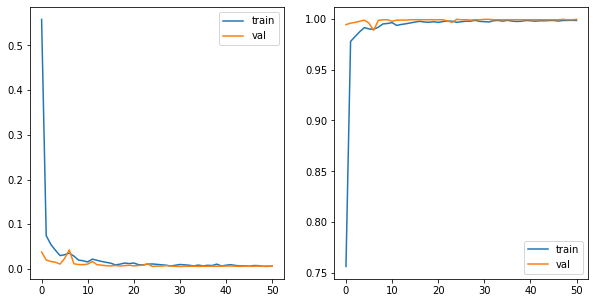

In [11]:
%%time
dict_pred = defaultdict(list)
file_names = []
for line in test_dataset.imgs:
    file_names.append(str(line).split('/')[-1].split('.')[0])

dict_pred['id'] = file_names

for i in trange(7):
    set_seed(SEED+i)
    
    train_nrj_loader, val_nrj_loader = load_split_train_valid(datadir=train_nrj_dir,                                                              
                                                              batch_size=BATCH_SIZE,
                                                              train_transforms=train_transforms,
                                                              valid_transforms=testval_transforms,
                                                              valid_size = .2)
    
    net = CNNc6()
    net = net.to(device)
    
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
    hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val =\
    train_model(net, loss, optimizer, scheduler, EPOCHS, train_nrj_loader, val_nrj_loader);
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(hystory_loss_train, label='train')
    ax1.plot(hystory_loss_val, label='val')
    ax1.legend()

    ax2.plot(hystory_acc_train, label='train')
    ax2.plot(hystory_acc_val, label='val')
    ax2.legend()
    
    net.eval()
    dict_pred[f'CNNc6-{i}'] = []
    with torch.no_grad():
        for _, (img, name) in enumerate(tqdm(test_loader)):
            img = img.to(device)
            outputs = net(img)
            _, predicted = torch.max(outputs.data, dim=1)
            predicted = list(map(int, predicted.cpu()))
            dict_pred[f'CNNc6-{i}'].extend(predicted)

    del net
    torch.cuda.empty_cache()

In [12]:
data_frame = pd.DataFrame.from_dict(dict_pred)
data_frame.head()

ValueError: arrays must all be same length

In [ ]:
data_frame['CNNc6-0'] = data_frame['CNNc6-0'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc6-1'] = data_frame['CNNc6-1'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc6-2'] = data_frame['CNNc6-2'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc6-3'] = data_frame['CNNc6-3'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc6-4'] = data_frame['CNNc6-4'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc6-5'] = data_frame['CNNc6-5'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})
data_frame['CNNc6-6'] = data_frame['CNNc6-6'].replace({
    0: 1.0, 
    1: 10.0,
    2: 20.0,
    3: 3.0,
    4: 30.0, 
    5: 6.0})

In [ ]:
data_frame['id'] = data_frame['id'].apply(lambda x: x.split('\\\\')[1])
data_frame.head()

In [ ]:
data_frame.to_csv('CNNc6.csv', index=False, header=True)